# Learning curve demo

_Nima Riahi, 2017-04-23_

Illustrate the learning-curve concept using simulated data.

A random data generation mechanism is defined (allowing linear and polynomial dependency) and the model training and test performance is computed for different training set sizes. Different model types can be investigated:

- OLS linear regression
- support vector regression
- decision tree regression

Particular didactic value arises from comparing learning curves for the OLS linear regressor for simulated data with linear versus non-linear dependency.

The first few cells define functionality. The second-last code cell is for playing around :-)


## Define source mechanism

The source mechanism is defined. It takes a set of input variabes (columns in a matrix), here simulated as random iid gaussian signals, and transforms them linearly or non-linearly into a scalar target signal.

Also, an RMS function is defined.

In [44]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeRegressor


def source(X, nonlins=None, sd_noise=0.5):
    """
    
    Generate data by transforming some input signal
    
    @param X (N,p) Input signals, e.g. zero mean gaussian columns
    @param sourceParams (p,) parameters of source. Signal column 'i' is raised 
        to the power sourceParams[i]. An array of all ones defines a linear model
    @param sd_noise Standard dev. of noise on output
    
    """
    
    if nonlins is None:
        nonlins = np.ones(X.shape[1])
            
    y = np.zeros((X.shape[0],1))
    for i in np.arange(len(nonlins)):
        y = y + np.power(X[:,i,np.newaxis],nonlins[i])
        
    # Add noise
    y = y + np.random.randn(y.shape[0],y.shape[1])*sd_noise

    return(y)


def rms(x):
    return(np.sqrt(np.mean(np.power(x,2))))



## Find best paramters for model

Using the built-in cross-validation mechanisms from `sklearn`. Not applicable for linear regressor.

In [2]:

# Simulate data for model parameter estimation
nonlins = np.array([1,1,1,1])
N = 10000  # Number of data samples

X = np.random.randn(N, len(nonlins))
y = source( X , nonlins=nonlins, sd_noise=0.5)

## Split the dataset in two equal parts
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.5, random_state=0)

# # Parameter tuning for Support Vector Regressor
# param_grid = [
#   {'C': [1, 100, 300], 'kernel': ['rbf']}]
# 
# clf = GridSearchCV(SVR(C=1), param_grid, cv=5)
# clf.fit(X, y)


# Same same but for decision trees
param_grid = [
  {'max_depth': [2,3,4,5,6,7,8,9,10]}]

clf = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
clf.fit(X, y)

print(clf.best_params_)

# clf.get_params()


{'max_depth': 10}


## Compute fit performance for various training set sizes

Estimate training and test error for various training set sizes. At each of these training set sized the errors are computed over `B` repetitions. The test set size is held fix (`ntest`).

The procedure to compute the learning curve is encapsulated into the function `LearningCurve`.

### Define Learning Curve function


In [3]:
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_predict


def learningCurve(M, ntrain_vec, ntest, B, source=None, nonlins=None):
    """
    Compute the learning curve for a given model. 
    
    @param M The learning model (e.g. linear regression, SVR, decision tree)
    @param ntrain_vec A vector containing the training set sizes (should be monotonically 
        increasing)
    @param ntest The test set size
    @param B Repetitions per training set size (to stabilize train/test error estimation)
    @param source Source (function): y = source(X, sourceParams)
    @param nonlins Source parameters (dict)
    
    """

    # Preallocate test/train error vectors
    testerr = np.zeros(len(ntrain_vec), dtype='float')
    trainerr = np.zeros(len(ntrain_vec), dtype='float')

    # Loop over training set sizes
    for i,ntrain in zip(np.arange(len(ntrain_vec)),ntrain_vec):

        # For each training set size perform B runs and compute mean RMS of error
        # First: preallocate variables for the train/test errors of the B runs
        testerrB = np.zeros(B, dtype='float')
        trainerrB = np.zeros(B, dtype='float')

        # Loop over B runs
        for k in np.arange(B):

            # Simulate data
            X = np.random.randn(ntrain+ntest, len(nonlins))
            y = source( X , nonlins, sd_noise=0.5)

            # Create train and test set
            #perm = np.random.permutation(np.arange(ntrain+ntest))
            #Xl = X[perm[0:ntrain],:]
            #yl = y[perm[0:ntrain]]
            #Xt = X[perm[ntrain:],:]
            #yt = y[perm[ntrain:]]
            Xtrain = X[0:ntrain,:]
            ytrain = y[0:ntrain]
            Xtest = X[ntrain:,:]
            ytest = y[ntrain:]

            
            
            # There's an odd effect here: if the model is first fit (M.fit()) and 
            # then a prediction is performed the results don't make sense (i.e. in 
            # the linear case the training error is about three times the noise std).
            # The problem doesn't occur when chaining fitting and prediction (M.fit().predict())

            ## Predict on test and learning data
            #M.fit(Xl, yl.ravel())
            #yl_ = M.predict(Xl)
            #yt_ = M.predict(Xt)

            # Predict on test and learning data
            ytrain_ = M.fit(Xtrain,ytrain).predict(Xtrain)
            ytest_ = M.fit(Xtrain,ytrain).predict(Xtest)

            #ytrain_ = M.fit(Xtrain, ytrain).predict(ytrain)
            #ytrain_ = M.predict(Xtrain)
            #ytest_ = M.predict(Xtest)

            # RMS errors
            testerrB[k] = rms( ytest.ravel() - ytest_.ravel() )
            trainerrB[k] = rms( ytrain.ravel() - ytrain_.ravel())


        # RMS of test error
        testerr[i] = np.mean(testerrB)
        trainerr[i] = np.mean(trainerrB)

    return({'testError':testerr, 'trainError':trainerr, 'ntrainVec':ntrain_vec})
    
    

### Perform computations

Perform actual computations using the function defined above. Most of the instructive parameters can be set here.

In [42]:
np.random.seed(3)

# Number of samples to estimate train/test error for given training/test size
B = 40

# Testset size
ntest = 100

##############################
# Training and test set sizes
ntrain_vec = np.array([50,100,200,300])  # for SVR
#ntrain_vec = np.arange(5,600,10)  # for decision tree example
#ntrain_vec = np.arange(6,70,2)  # for linear regressor

##############################
# Define model class (linear, SVR, DecisionTree)
#M = linear_model.LinearRegression(fit_intercept=True)
M = SVR(kernel='rbf', 
        gamma='auto', coef0=0.0, 
        tol=0.001, 
        C=100., epsilon=0.1, shrinking=True, 
        cache_size=200)
#M = DecisionTreeRegressor(max_depth=5)


##############################
# Compute training and test errors
# 
trainCurve = learningCurve(M, ntrain_vec, ntest, B, source=source, nonlins=[1,1,1,1])



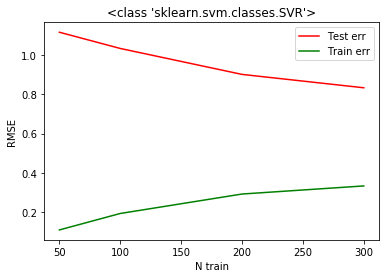

In [43]:
# Plot learning curve
# For linear regressor and linear source function the sill of the lines should approach 'sd_noise'

plt.cla()
plt.plot(trainCurve['ntrainVec'], trainCurve['testError'],'-', color='red')
plt.plot(trainCurve['ntrainVec'], trainCurve['trainError'],'-', color='green')
plt.legend(['Test err','Train err'])
plt.xlabel('N train')
plt.ylabel('RMSE')
plt.title(type(M))
plt.show()
